# Configuration
Necessary imports and required parameters like dataset/checkpoint path.

In [1]:
import os.path as osp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import torch
from bvpr.util import process_config
from bvpr.models import SegmentationModel as Model
from bvpr.datamodule import SegmentationDataModule as DataModule

In [2]:
DATASET_NAME = "unc"
DATASET_PATH = "~/data/refexp/data"
CHECKPOINT_PATH = "~/model.ckpt"
DEVICE = "cuda:0"
THRESHOLD = 0.40

# do not touch below
CHECKPOINT_PATH = osp.abspath(osp.expanduser(CHECKPOINT_PATH))
data_config = {
    "image_size": 640,
    
    "dataset": {
        "dataset": DATASET_NAME,
        "data_root": DATASET_PATH,
    },
    
    # just in case
    "loader": {
        "num_workers": 0,
        "pin_memory": False,
        "batch_size": 1,
    }
}

# Load Data and Model

In [3]:
device = torch.device(DEVICE)
dm = DataModule(data_config)
dm.setup(stage="test")
ckpt = torch.load(CHECKPOINT_PATH)
state_dict = ckpt["state_dict"].items()
state_dict = {".".join(k.split(".")[1:]): v for (k, v) in state_dict}
model_config = ckpt["hyper_parameters"]["model"]
model = Model(model_config).to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

# Generate Segmentation

In [4]:
# variables -- feel free to change
DATASET_ID = 0
EXAMPLE_ID = 0
PHRASE = None

# prepare data
test_data = dm.test_datasplits[DATASET_ID]
image_file, mask_file, phrase = test_data.images[EXAMPLE_ID]
phrase = phrase if PHRASE is None else PHRASE
image = test_data.read_image(image_file)
gold = torch.load(osp.join(test_data.mask_dir, mask_file))

# predict mask
img = test_data.transform(image[0]).to(device).unsqueeze(0)
txt = test_data.tokenize_phrase(phrase).to(device).unsqueeze(1)
size = image[1].unsqueeze(0)
h, w = image[0].shape[:2]
predicted = model(img, txt, size)[-1].squeeze()
predicted = torch.sigmoid(predicted) >= THRESHOLD
predicted = predicted[:h, :w].float().detach().cpu()

# Visualize

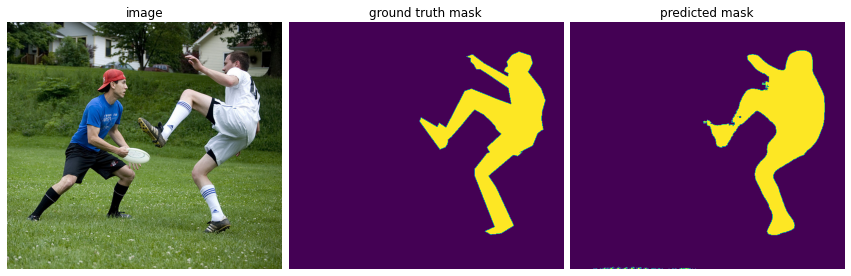

phrase: guy flopping around on the right


In [5]:
%matplotlib inline
scale = 5.
fig = plt.figure(figsize=(3 * scale, scale))
grid = ImageGrid(
    fig, 111, nrows_ncols=(1,3), axes_pad=0.1)

images = [
    ("image", image[0]),
    ("ground truth mask", gold),
    ("predicted mask", predicted),
]

for ax, (title, im) in zip(grid, images):
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(im)
plt.show()
print(f"phrase: {phrase}")